In [98]:
# Installing dependencies
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Elabore um problema de busca por raizes e o resolva

Você é um engenheiro elétrico e está trabalhando em um projeto de energia solar. O objetivo é determinar os parâmetros do modelo de um painel solar com base em dados experimentais. O modelo de um painel solar pode ser descrito pela seguinte equação:
[Referencia](https://www.mdpi.com/1996-1073/16/4/2018)

![](./assets/panel_electric_model.jpg)

$$
I = I_{l} - I_0 \left( e^{\frac{V + IR_s}{nV_T}} - 1 \right) - \frac{V + IR_s}{R_{sh}}
$$

Onde:

- $I$ é a corrente de saída do painel solar.
- $I_{l}$ é a corrente fotogerada.
- $I_0$ é a corrente de saturação reversa do diodo.
- $V$ é a tensão de saída do painel solar.
- $R_s$ é a resistência série.
- $R_{sh}$ é a resistência shunt.
- $n$ é o fator de idealidade do diodo.
- $V_T$ é a tensão térmica.

## Dados (para fins didaticos algumas constantes do painel ja foram achadas):

- $V_T = 26$ mV
- $I_L = 0.226 \, \text{A}$
- $I_0 = 7.270 \times 10^{-18} \, \text{A}$
- $n = 0.572$
- $R_{sh} = 90.319 \, \Omega$
- $R_{s} = [1m\Omega, 500m\Omega]$

## Problema
Ache os valores de $R_s$ que melhor se ajustam aos dados experimentais abaixo:

- V (V): 0.5
- I (A): 0.14










## Resolução do problema

Para achar o valor de Rs tem que seguir os seguintes passos:
- Manipular a equação para que fique na forma $f(Rs) = 0$
- Resolver por metodos numericos
  - Grafico
  - Busca Incremental
  - Bisseção
  - Newton-Raphson



### Manipulando a equação

$$
f(R_s) = I_{l} - I_0 \left( e^{\frac{V + IR_s}{nV_T}} - 1 \right) - \frac{V + IR_s}{R_{sh}} - I
$$


### Adicionando a equação no python

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class Panel:
	# Defining the solar panel parameters

	# output voltage
	V: float
	# output current
	I: float
	# Photogenerated current
	Il: float
	# diode reverse current
	Io: float
	# thermal voltage
	Vt: float
	# diode non-ideality factor
	n: float
	# shunt/parallel resistance related to a current loss due to current leaks on the cell
	Rsh: float

	# Defining the function that characterize the solar panel depending on the R_s
	def f(self, x: float) -> float:
		return self.Il - self.Io * (np.exp((self.V + self.I * x) / self.Vt) - 1) - ((self.V + self.I * x) / self.Rsh) - self.I

# Defining the solar panel parameters
panel = Panel(
	Vt = 26e-3,
	Il = 0.226,
	Io = 7.270e-11,
	n = 0.572,
	Rsh = 90.319,
	V = 0.5,
	I = 0.14
)



### Metodo grafico

Baseado no metodo grafico, o valor de Rs é aproximadamente 0.295

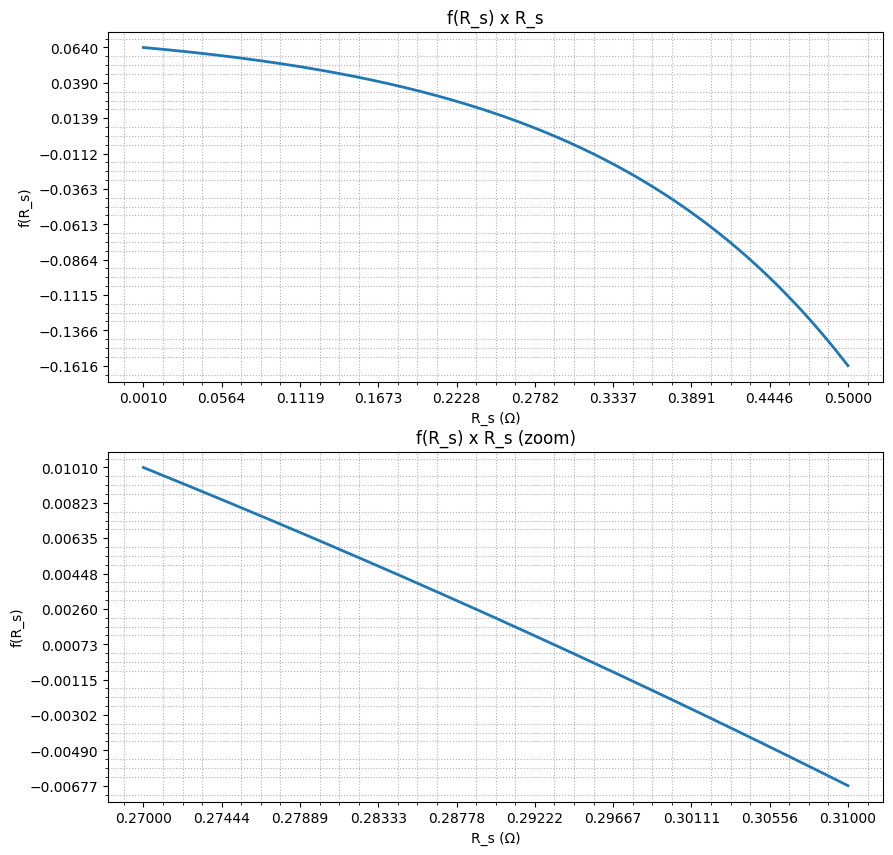

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the R_s range
x = np.linspace(1e-3, 500e-3, 1000)

# Ploting the graph
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(
	x,
	panel.f(x),
	linewidth=2,
)

axs[0].set_title('f(R_s) x R_s')
# Improve ticks to be equal for x and y
axs[0].minorticks_on()
axs[0].grid(which='major', linestyle='-')
axs[0].grid(which='minor', linestyle=':')
axs[0].set_xticks(np.linspace(x.min(), x.max(), 10))
axs[0].set_yticks(np.linspace(panel.f(x).min(), panel.f(x).max(), 10))

axs[0].set_xlabel('R_s (Ω)')
axs[0].set_ylabel('f(R_s)')
axs[0].grid()

x = np.linspace(0.270, 0.310, 1000)
axs[1].plot(
	x,
	panel.f(x),
	linewidth=2,
)

axs[1].set_title('f(R_s) x R_s (zoom)')
# Improve ticks to be equal for x and y
axs[1].minorticks_on()
axs[1].grid(which='major', linestyle='-')
axs[1].grid(which='minor', linestyle=':')
axs[1].set_xticks(np.linspace(x.min(), x.max(), 10))
axs[1].set_yticks(np.linspace(panel.f(x).min(), panel.f(x).max(), 10))

axs[1].set_xlabel('R_s (Ω)')
axs[1].set_ylabel('f(R_s)')
axs[1].grid()




### Metodo da busca incremental

In [94]:
# Incremental search method

def incremental_search(f, a, b, dx):
	# Defining the f(a) and f(b) values
	fa = f(a)
	fb = f(b)

	# If f(a) and f(b) have the same sign, there is no root between a and b
	if np.sign(fa) == np.sign(fb):
		print('There is no root between a and b')
		return None

	# If f(a) is 0, a is a root
	if fa == 0:
		print('a is a root')
		return a

	# If f(b) is 0, b is a root
	if fb == 0:
		print('b is a root')
		return b

	# Starting the incremental search
	c = a

	iteration = 0
	
	while c < b:
		# Incrementing the iteration
		iteration += 1

		# Defining the f(c) value
		fc = f(c)

		# If f(c) is 0, c is a root
		if fc == 0:
			return {"solution": c, "iterations": iteration}

		# If the product between f(a) and f(c) is less than 0, there is a root between a and c
		if np.sign(fa) * np.sign(fc) < 0:
			# Returning the c value
			return {"solution": c, "iterations": iteration}

		# Incrementing the c value
		c += dx

	# If none of the above conditions are satisfied, there is no root between a and b
	print('Root not found')
	return None

# Defining the R_s minimum and maximum values
a = 1e-3
b = 500e-3

# Defining the dx value
dx = 1e-6

# Running the incremental search method
out = incremental_search(panel.f, a, b, dx)

# Printing the R_s value
print(f'R_s = {out["solution"]} Ω, iterations = {out["iterations"]}')


R_s = 0.2949639999990263 Ω, iterations = 293965


### Metodo da bisseção

In [95]:
# Bisection method

from collections.abc import Callable

def bisection(f: Callable[[float], float], a: float, b: float, tol: float, max_iteration: int = 1000) -> dict | None:
	# Defining the f(a) and f(b) values
	fa = f(a)
	fb = f(b)

	# If f(a) and f(b) have the same sign, there is no root between a and b
	if np.sign(fa) == np.sign(fb):
		print('There is no root between a and b')
		return None

	# Starting the bisection method
	c = (a + b) / 2
	fc = f(c)

	iteration = 0

	while np.abs(fc) > tol and max_iteration - iteration > 0:
		# Incrementing the iteration value
		iteration += 1

		# If f(c) is 0, c is a root
		if fc == 0:
			return {
				"x": c,
				"itertions": iteration
				}

		# If the product between f(a) and f(c) is less than 0, there is a root between a and c
		if np.sign(fa) * np.sign(fc) < 0:
			# Updating the b value
			b = c
			fb = fc
		# If the product between f(b) and f(c) is less than 0, there is a root between b and c
		elif np.sign(fb) * np.sign(fc) < 0:
			# Updating the a value
			a = c
			fa = fc

		# Updating the c value
		c = (a + b) / 2
		fc = f(c)

	if iteration == max_iteration:
		print('Maximum number of iterations reached')
		return None
	# Returning the c value
	return {
			"solution": c,
			"itertions": iteration
		}


# Defining the R_s minimum and maximum values
a = 1e-3
b = 500e-3

# Defining the tolerance
tol = 1e-12

# Running the bisection method
out = bisection(panel.f, a, b, tol)

# Printing the R_s value
print(f'R_s = {out["solution"]} Ω in {out["itertions"]} iterations')



R_s = 0.29496396953286597 Ω in 30 iterations


### Metodo de Newton-Raphson

In [96]:
# Newton-Raphson method

import sympy as sym
from collections.abc import Callable

def newton_raphson(f: Callable[[float], float], df: Callable[[float], float], x0: float, tol: float, max_iteration: int = 1000) -> dict:
	# Starting the Newton-Raphson method
	iteration = 0
	x = x0
	fx = f(x)
	while np.abs(fx) > tol and max_iteration - iteration > 0:
		# Incrementing the iteration value
		iteration += 1

		# Calculating the new x value
		x = x - fx / df(x)
		# Calculating the new f(x) value
		fx = f(x)

	if iteration == max_iteration:
		print('Maximum number of iterations reached')
		return None
	# Returning the x value
	return {'solution': x, 'iters': iteration}


# Defining symbols
R_s = sym.Symbol('R_s')
V = sym.Symbol('V')
I = sym.Symbol('I')
Il = sym.Symbol('Il')
Io = sym.Symbol('Io')
Vt = sym.Symbol('Vt')
Rsh = sym.Symbol('Rsh')

# Defining the f(R_s) symbolic function
f = Il - Io * (sym.exp((V + I * R_s) / Vt) - 1) - ((V + I * R_s) / Rsh) - I

# Defining the df(R_s) symbolic function
df = sym.diff(f, R_s)

# lambda function for df(R_s)
df_lambda = sym.lambdify(R_s, df.subs({
	V: panel.V,
	I: panel.I,
	Il: panel.Il,
	Io: panel.Io,
	Vt: panel.Vt,
	Rsh: panel.Rsh
}))

# Defining the R_s initial value
x0 = 0

# Running the Newton-Raphson method
out = newton_raphson(panel.f, df_lambda, x0, 1e-12)

# Printing the R_s value
print(f'R_s = {out["solution"]} Ω in {out["iters"]} iterations')


R_s = 0.2949639695323982 Ω in 8 iterations
